In [20]:
import pandas as pd
from dbgsom.dbgsom_ import DBGSOM
import seaborn.objects as so
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from skimage.color import lab2rgb

In [2]:
data = pd.read_csv(
    "F:\Dokumente\git\data\CIC-Darknet2020\Darknet.CSV",
    index_col="Flow ID",
    parse_dates=["Timestamp"],
).dropna()


In [3]:
data.replace(
    {
        -np.inf: 0,
        np.inf: 0,
        "AUDIO-STREAMING": "Audio-Streaming",
        "File-transfer": "File-Transfer",
        "Video-streaming": "Video-Streaming",
    },
    inplace=True,
)
data.Timestamp = data.Timestamp.astype("int64")
X = data.drop(columns=["Label", "Label.1"])
y_1 = data["Label"]
y_2 = data["Label.1"]

X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = train_test_split(
    X, y_1, y_2, random_state=23, stratify=y_2
)


In [229]:
scaler = StandardScaler()
ohe = OneHotEncoder(max_categories=10, handle_unknown="infrequent_if_exist")
col_transformer = ColumnTransformer(
    transformers=[("ohe", ohe, ["Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol"])],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
som = DBGSOM(
    max_epochs=300,
    spreading_factor=0.02,
    max_neurons=300,
    # metric="cosine",
    # vertical_growth=True,
    threshold_method="se",
    # growth_criterion="entropy",
    min_samples_vertical_growth=200,
)

pipe = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("scaler", scaler),
        ("som", som),
    ]
)

# y_train = y_1_train
y_train = y_2_train


In [230]:
pipe.fit(X_train, y_train)


 62%|██████▏   | 186/300 [01:44<01:04,  1.78 epochs/s]


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=10),
                                                  ['Src IP', 'Src Port',
                                                   'Dst IP', 'Dst Port',
                                                   'Protocol'])],
                                   verbose_feature_names_out=False)),
                ('scaler', StandardScaler()),
                ('som',
                 DBGSOM(max_epochs=300, max_neurons=300,
                        min_samples_vertical_growth=200,
                        spreading_factor=0.02))])

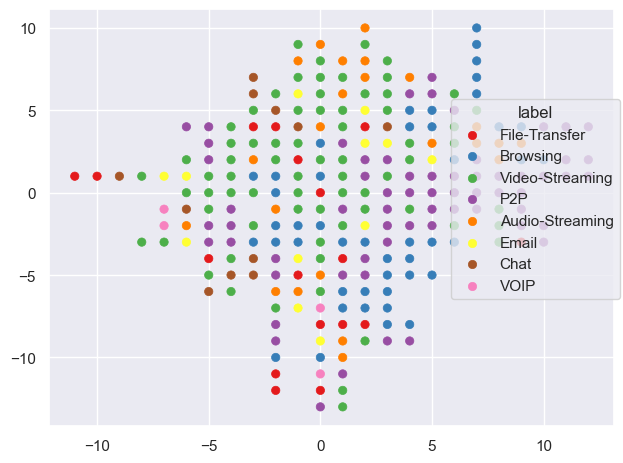

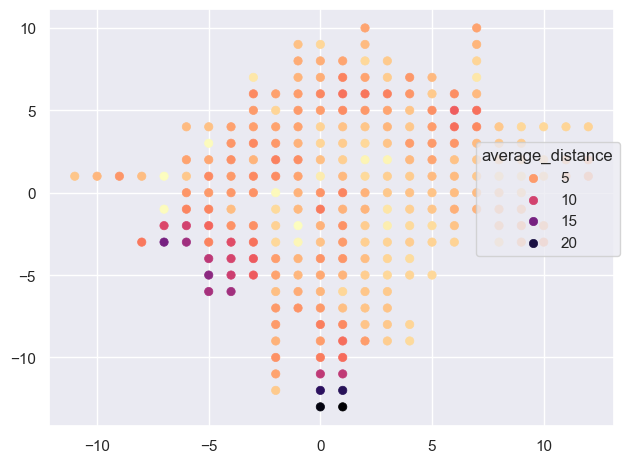

In [231]:
som.plot(
    color="label",
    palette="Set1",
    # pointsize="epoch_created",
)
som.plot(
    color="average_distance",
    # palette="Set1",
    # pointsize="error",
)


In [232]:
weights = pd.DataFrame.from_dict(dict(som.som_.nodes)).T.set_index(
    np.arange(len(som.som_.nodes))
)["weight"]

weights_split = pd.DataFrame((pd.Series(feature) for feature in weights))
weights_split.columns = columns = col_transformer.get_feature_names_out()


In [260]:
pca = PCA(n_components=3)
pca_components = pca.fit(scaler.transform(col_transformer.transform(X_train))).transform(
    weights_split
)


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [274]:
colors_lab = pca_components
colors_lab[:, 0] = minmax_scale(colors_lab[:, 0], (0, 100))
colors_lab[:, 1] = minmax_scale(colors_lab[:, 1], (-127, 127))
colors_lab[:, 2] = minmax_scale(colors_lab[:, 2], (-127, 127))

colors_rgb = lab2rgb(colors_lab)


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return func(*args, **kwargs)


<Axes: >

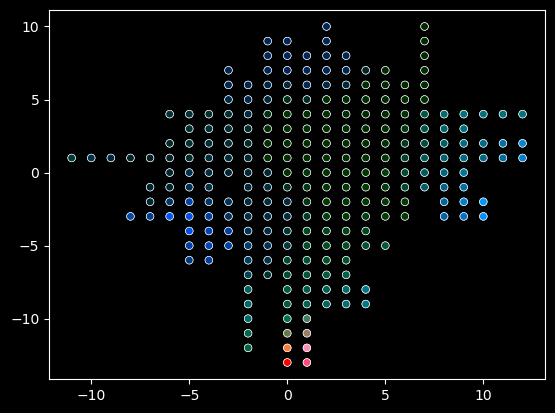

In [283]:
sns.scatterplot(
    x=np.array(som.som_.nodes)[:, 0],
    y=np.array(som.som_.nodes)[:, 1],
    # color=minmax_scale(pca_components),
    color=colors_rgb,
    # c=weights_split["Average Packet Size"],
    legend="full",
    s=30,
)


<Axes: >

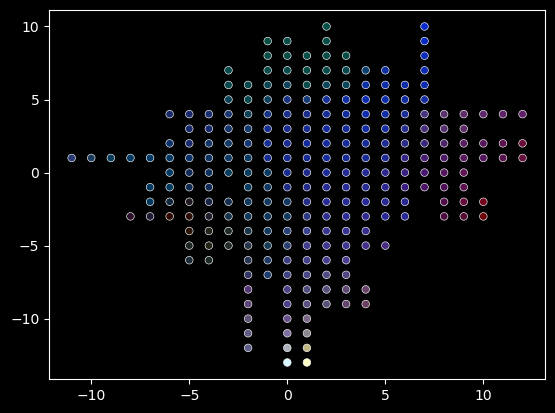

In [284]:
sns.scatterplot(
    x=np.array(som.som_.nodes)[:, 0],
    y=np.array(som.som_.nodes)[:, 1],
    color=minmax_scale(pca_components),
    # color=colors_rgb,
    # c=weights_split["Average Packet Size"],
    legend="full",
    s=30,
)

In [252]:
som.topographic_error_


0.058965998190591076

In [253]:
pipe.score(X_test, y_2_test)


0.7947188374657205

In [254]:
f1_score(
    y_2_test,
    pipe.predict(X_test),
    # average="macro",
    average=None,
)


array([0.76382502, 0.86244827, 0.53264061, 0.55953017, 0.52872004,
       0.96309784, 0.4921781 , 0.50588713])

In [255]:
col_transformer.get_feature_names_out()[np.argmax(np.abs(pca.components_), axis=1)]

array(['Bwd IAT Total', 'Average Packet Size', 'FIN Flag Count'],
      dtype=object)

In [256]:
# so.Plot(
#     np.array(som.som_.nodes)[:, 0], np.array(som.som_.nodes)[:, 1], color=colors_tuple
# ).add(so.Dots()).scale()


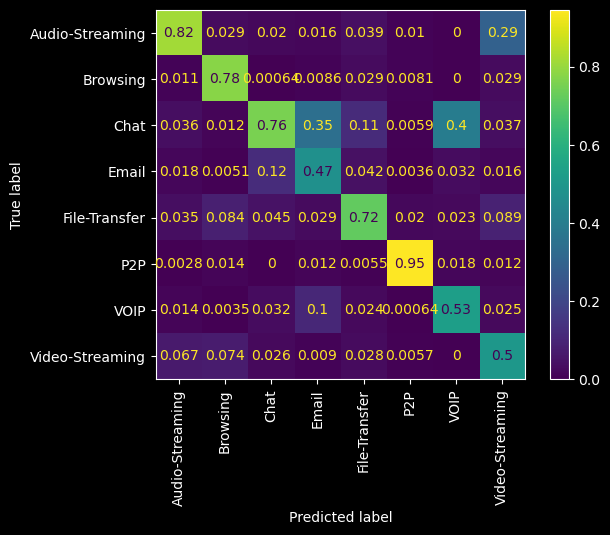

In [257]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_2_test,
    pipe.predict(X_test),
    normalize="pred",
    xticks_rotation="vertical",
)


In [258]:
len(som.neurons_)

245